# Evaluating the Performance of MiDaS on Drone Data
---

In [1]:
bag_file_name = 'test3.bag'

## Getting drone footage

In [2]:
import os
import rosbag
import bag2data as b2d
import cv2
import matplotlib.pyplot as plt
import numpy as np
import run

bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

# get data from rosbag
image_data_infra1_ros = b2d.getImageData(bag, '/d455/infra1/image_rect_raw')
image_data_infra2_ros = b2d.getImageData(bag, '/d455/infra2/image_rect_raw')

# transform data into list of numpy arrays/matrices
image_data_infra1_np = b2d.ros_IMG_2numpy(image_data_infra1_ros)
image_data_infra2_np = b2d.ros_IMG_2numpy(image_data_infra2_ros)

print("The bags contain", len(image_data_infra1_np), "and", len(image_data_infra2_np), "Frames.")

c:\Users\User\.conda\envs\midas-performance-py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The bags contain 843 and 840 Frames.


## Estimating depth in drone footage

In [3]:
# run MiDaS on data from rosbag
# python ./MiDaS/run.py --model_type dpt_beit_large_512 --input_path input --output_path output
input_path = 'input'
output_path = 'output'
model_path = 'weights/dpt_beit_large_512.pt'
model_type = 'dpt_beit_large_512'
optimize=False
side=False
height=None
square=False
grayscale=True # Realsense output is grayscale
run.run(input_path, output_path, model_path, model_type, optimize, side, height, square, grayscale)

Initialize
Device: cpu


c:\Users\User\.conda\envs\midas-performance-py310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model loaded, number of parameters = 345M
Start processing
  Processing input\0.png (1/3)
    Input resized to 896x512 before entering the encoder
  Processing input\1.png (2/3)
    Input resized to 896x512 before entering the encoder
  Processing input\2.png (3/3)
    Input resized to 896x512 before entering the encoder
Finished


In [4]:
# img = cv2.imread('output/0-dpt_beit_large_512.png')
folder = 'output'
depth_estimate_images = b2d.load_images_from_folder(folder)

# plt.imshow(images[1]) # cmap='gray'
# plt.show()

### Getting ONE example index for the two extremes of the depth map 
# ind_max = np.unravel_index(np.argmax(images[0], axis=None), images[0].shape)
# ind_min = np.unravel_index(np.argmin(images[0], axis=None), images[0].shape) # returns (x,y,RBG) with RBG being 3 dims; returns RGB = 0 for grayscale

## Getting "real" depth from Intel Realsense

In [5]:
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

depth_data_ros = b2d.getDepthData(bag, '/d455/depth/image_rect_raw')

#print(depth_data_ros[0])

depth_measurement_images = b2d.ros_DEPTH_2numpy(depth_data_ros)


max_depth = depth_measurement_images[0].max()

max_depth

### get second largest value
# flat=depth_measurement_images[0].flatten()
# flat.sort()
# uniques = np.unique(flat)
# second_largest = uniques[-2]
# second_largest

# plt.imshow(depth_data[1]) # cmap='gray'
# plt.show()

65535

## Comparing estimation to "ground truth"

In [6]:
'''
We have:
    - depth_estimate_images         [0-255]
    - depth_measurement_images      [0-65535] in mm // TODO: really mm? Have to check!
'''

difference_pic_zero = depth_estimate_images[0]/255 + depth_measurement_images[0]/65535


## Results

In [7]:
print(difference_pic_zero.max())
print(difference_pic_zero.min())

1.9137254901960783
0.0


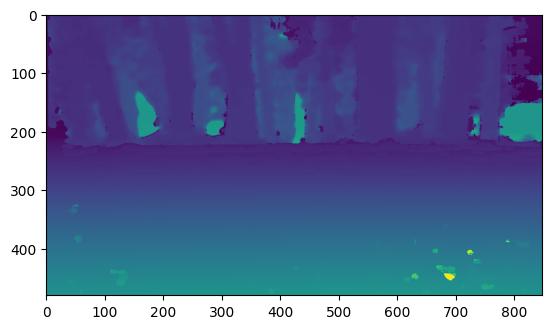

In [8]:
plt.imshow(difference_pic_zero) # cmap='gray'
plt.show()

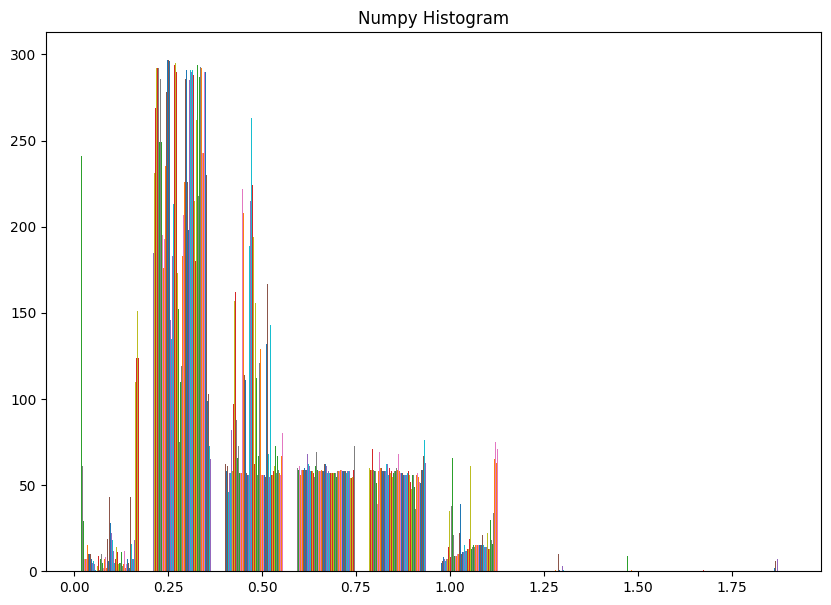

In [10]:
fig = plt.figure(figsize =(10, 7))

plt.hist(difference_pic_zero) #, bins='auto'

plt.title("Numpy Histogram")
plt.show()